In [1]:
import numpy as np
from data_generator import AudioGenerator, vis_train_features, plot_spectrogram_feature, plot_mfcc_feature, plot_raw_audio
from sample_models import final_model, own_model
from keras.models import load_model
from keras import backend as K
from keras.layers import (GRU)
from train_utils import train_my_model, train_model
from utils import int_sequence_to_text
from IPython.display import Audio, HTML
import tensorflow as tf
from text import correction
import os

Using TensorFlow backend.


In [21]:
def plot_audio_visualizations(index=0):  
    # plot audio visualizations
    vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features(index=index)
    plot_spectrogram_feature(vis_spectrogram_feature)
    plot_mfcc_feature(vis_mfcc_feature)
    plot_raw_audio(vis_raw_audio)

In [12]:
def get_predictions(index, partition, trained_model, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        trained_model (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=False)
    data_gen.load_train_data()
    data_gen.load_validation_data()
        
    # obtain the true transcription and the audio features from Dataset
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')

    print("Trained model output length:\n" + str(trained_model.output_length(data_point.shape[0])))
    # obtain and decode the acoustic model's predictions
    trained_model.load_weights(model_path)
    prediction = trained_model.predict(np.expand_dims(data_point, axis=0))
    output_length = [trained_model.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                        prediction, output_length)[0][0])+1).flatten().tolist()
    
    transcription = ''.join(int_sequence_to_text(pred_ints))
    # Correction using KenLM language model toolkit
    corrected_transcription = correction(transcription)
 
    print('-'*80)
    print(repr(audio_path).replace(r"\\", r"/"))
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Raw prediction:\n' + str(prediction[0]))
    print('CTC Decoded predicted Ints before conversion to text:\n' + str(pred_ints))
    print('Predicted transcription:\n' + '\n' + transcription)
    print('Predicted transcription with correction:\n' + corrected_transcription)
    print('-'*80)

In [8]:
model_end = final_model(input_dim=161, filters=200, kernel_size=11, conv_stride=2, conv_border_mode='valid', units=250, activation='relu', cell=GRU, dropout_rate=1, number_of_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
layer_1_conv (Conv1D)        (None, None, 200)         354400    
_________________________________________________________________
conv_batch_norm (BatchNormal (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 250)         338250    
_________________________________________________________________
bt_rnn_1 (BatchNormalization (None, None, 250)         1000      
_________________________________________________________________
final_layer_of_rnn (GRU)     (None, None, 250)         375750    
_________________________________________________________________
bt_rnn_final (BatchNormaliza (None, None, 250)         1000      
__________

In [24]:
get_predictions(index=2, partition='train', trained_model=model_end, model_path='results/model_end.h5')

Trained model output length:
490
--------------------------------------------------------------------------------
'LibriSpeech/dev-clean/1272/128104/1272-128104-0003.wav'
True transcription:

he has grave doubts whether sir frederick leighton's work is really greek after all and can discover in it but little of rocky ithaca
--------------------------------------------------------------------------------
Raw prediction:
[[  7.27922824e-08   2.89782642e-11   1.81597670e-07 ...,   2.38556458e-06
    1.41808520e-08   9.99963522e-01]
 [  2.26382326e-08   5.80344204e-13   2.65937370e-08 ...,   2.85374881e-07
    4.63680899e-10   9.99996781e-01]
 [  4.65074720e-07   9.61628607e-12   9.73985721e-07 ...,   3.82952612e-06
    1.75105141e-09   9.99979258e-01]
 ..., 
 [  2.24400701e-05   1.62360649e-07   2.69808595e-07 ...,   4.34979574e-06
    1.63829164e-08   9.99849319e-01]
 [  2.95425580e-05   3.79194688e-07   4.28392156e-07 ...,   6.14103874e-06
    2.30980692e-08   9.99801934e-01]
 [  3.4282

There are 2023 total training examples.


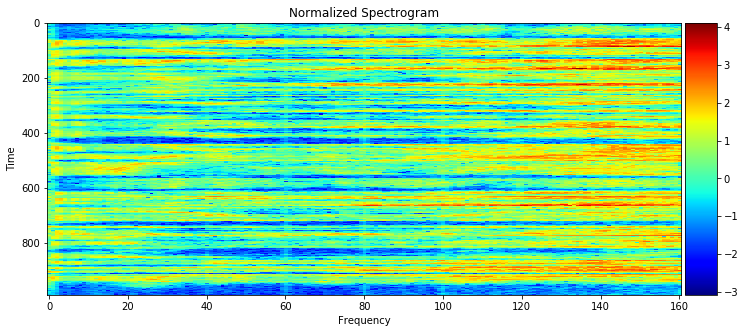

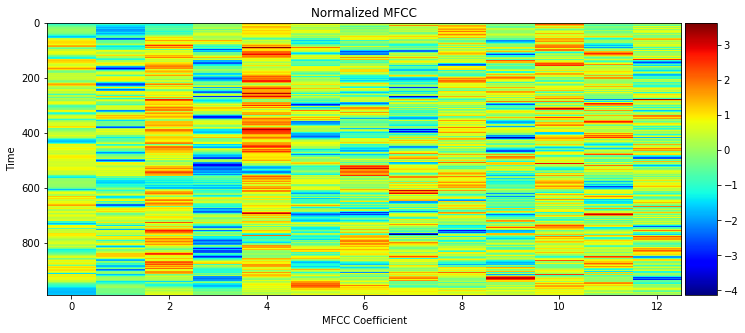

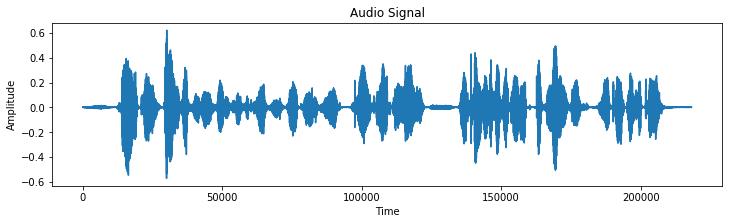

In [22]:
plot_audio_visualizations(index=2)

In [16]:
Audio('LibriSpeech/dev-clean/1272/128104/1272-128104-0003.wav')

(107, 161)


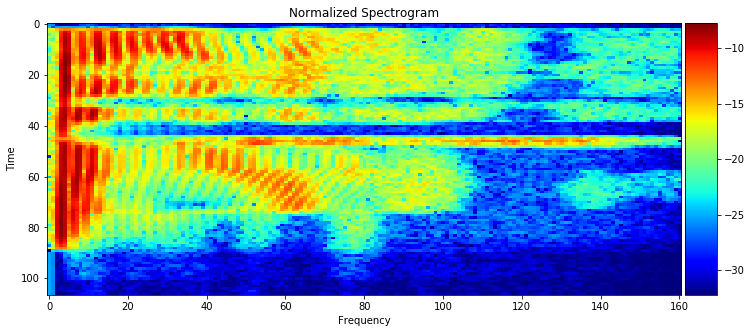

In [20]:
from utils import spectrogram_from_file
q = spectrogram_from_file(filename='audio/example.wav', max_freq=8000)
print(q.shape)
def normalize(samples):
    feat_mean = np.mean(q, axis=0)
    feat_std = np.std(q, axis=0)
    eps = 1e-14
    normalized = (q - feat_mean) / (feat_std + eps)    
    return normalized
plot_spectrogram_feature(q)

In [2]:
"""
 Gabriel Freire: My final compiled Model
 Optimizer: SGD
 Loss: CTC
 file: sample_models.py
"""
my_model = own_model(input_dim=161, output_dim=29)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 161)    644         the_input[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 200)    354400      batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 200)    440200      conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

In [ ]:
train_my_model(model=my_model, pickle_path='own_model_loss.pickle', save_model_path='own_model.h5', spectrogram=True)
# train_model(input_to_softmax=model_end, pickle_path='model_end2.pickle', save_model_path='model_end2.h5', spectrogram=True)

Num of training examples: 2703
Num of validation examples: 2620
Epoch 1/10
135/135 [==============================] - 11700s 87s/step - loss: 382.9253 - val_loss: 323.7032

Epoch 00001: saving model to results/own_model.h5
Epoch 2/10
135/135 [==============================] - 17089s 127s/step - loss: 317.2075 - val_loss: 316.4109

Epoch 00002: saving model to results/own_model.h5
Epoch 3/10
 11/135 [=>............................] - ETA: 4:24:02 - loss: 308.2640

In [8]:
# Example of javascript/HTML inside Jupyter notebook
pystartlife = str(100)
HTML("<div id='textid'>" + pystartlife + "</div>")

In [9]:

%%javascript --code
// Get the python variable from the DOM
var startlife = document.getElementById('textid').innerHTML;

// Define a User class with a method
function User() {
    this.name = '';
    this.life = Number(startlife);
    this.giveLife = function giveLife(targetPlayer) {
        targetPlayer.life += 1;
        this.life -= 1;
    }
}

// Use class
var Alfred = new User();
var Wallace = new User();

// Names were blank so give them name values
Alfred.name = 'Alfred';
Wallace.name = 'Wallace';

// Let's play a game!

// Let Alfred give life to Wallace
Alfred.giveLife(Wallace);

// Save these variables back to python variables to work with later
IPython.notebook.kernel.execute('Alfred_life="' + Alfred.life + '";');
IPython.notebook.kernel.execute('Wallace_life="' + Wallace.life + '";');

<IPython.core.display.Javascript object>

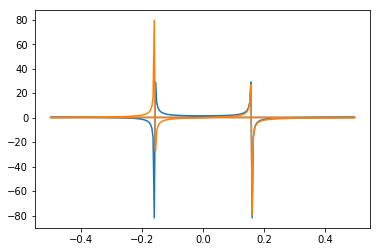

In [10]:
import matplotlib.pyplot as plt
t = np.arange(256)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, sp.real, freq, sp.imag)
plt.show()

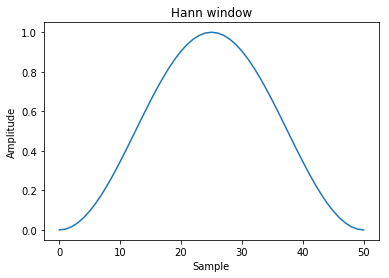

C:\Users\gabriel.freire\AppData\Local\Continuum\anaconda3\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


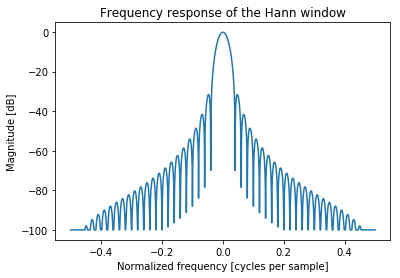

In [11]:
from numpy.fft import fft, fftshift
window = np.hanning(51)
plt.plot(window)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()
plt.figure()
A = fft(window, 2048) / 25.5
mag = np.abs(fftshift(A))
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(mag)
response = np.clip(response, -100, 100)
plt.plot(freq, response)
plt.title("Frequency response of the Hann window")
plt.ylabel("Magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")
plt.axis('tight')
plt.show()

In [ ]:
# Numpy implementation of a RNN layer - this implementation corresponds to the keras SimpleRNN
timesteps = 100 # number of timesteps in the input sequence
input_features = 32 # dimensionality of the input feature space
output_features = 64 # dimensionality of the output feature space

inputs = np.random.random((timesteps, input_features)) # input data: random nois for the sake of the example
state_t = np.zeros((output_features,)) # initial state: an all-zero vector
 
# creates random weight matrices
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
# input_t is a vector of shape (input_features, None)
for input_t in inputs:
    # this is the combination of the output with the current state activated by TANH -> prediction
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) 
    # stores this prediction/output in a list
    successive_outputs.append(output_t)
    # updates the state of the network for the next timestep
    state_t = output_t 
# the final output is a 2D tensor of shape (timesteps, output_features)
final_output_sequence = np.concatenate(successive_outputs, axis=0) 

In [ ]:
# Data normalization
some_float_data = np.random.random((90, 10))
mean = some_float_data.mean(axis=0)
std = some_float_data.std(axis=0)
some_float_data = (some_float_data - mean) / std